In [1]:
# @hidden_cell
import numpy as np
import pandas as pd
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

housing_df = pd.read_csv("../../data/Housing.csv")
housing_df['total_size'] = housing_df['floor_size']+housing_df['garage_size']
# housing_df['price_per_unit_area'] = (housing_df['sold_price']/housing_df['total_size']).round(2)

# Feature Engineering and Selection in practice

We have discussed a lot of feature engineering and feature selection techniques in the previous two sections of this chapter. Now it is time to apply some of them in practice for an actual regression problem.

We go back to the housing dataset that contains information on various property listings in Athens, Ohio. As a reminder, each listing is described through a number of features including floor area, garage area, bed room count etc. In addition, we also have information regarding a listing's selling price per unit area. We treat thus price as the outcome variable that we want to predict by fitting a linear regression model.  
Let us first take a look at the features available to us. 
<!-- We also do not use `sold_price` as a feature, when training the model, since that is the information which has been used to calculate the response variable `price_per_unit_area` by dividing the former by the listing's total area. -->

In [2]:
housing_df.head()

,floor_size,bed_room_count,built_year,sold_date,sold_price,room_count,garage_size,parking_lot,total_size
0,2068,3,2003,Aug2015,195500,6,768,3,2836
1,3372,3,1999,Dec2015,385000,6,480,2,3852
2,3130,3,1999,Jan2017,188000,7,400,2,3530
3,3991,3,1999,Nov2014,375000,8,400,2,4391
4,1450,2,1999,Jan2015,136000,7,200,1,1650


We also take a look at the different column types in the dataset and their corresponding non-null entry counts prior to proceeding with any feature engineering steps.

In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   floor_size      106 non-null    int64 
 1   bed_room_count  106 non-null    int64 
 2   built_year      106 non-null    int64 
 3   sold_date       106 non-null    object
 4   sold_price      106 non-null    int64 
 5   room_count      106 non-null    int64 
 6   garage_size     106 non-null    int64 
 7   parking_lot     106 non-null    int64 
 8   total_size      106 non-null    int64 
dtypes: int64(8), object(1)
memory usage: 7.6+ KB


We should also check for missing values and potential duplicates.

In [4]:
print("Missing values in each column:")
print(housing_df.isnull().sum())

Missing values in each column:
floor_size        0
bed_room_count    0
built_year        0
sold_date         0
sold_price        0
room_count        0
garage_size       0
parking_lot       0
total_size        0
dtype: int64


In [5]:
duplicate_count = housing_df.duplicated().sum()
print(f"\nNumber of duplicate records: {duplicate_count}")
housing_df = housing_df.drop_duplicates()
print("Number of records in deduplicated dataset:",len(housing_df))


Number of duplicate records: 1
Number of records in deduplicated dataset: 105


Prior to looking into possible feature engineering strategies, let us look at our target variable more closely. Here we plot the distribution of the `sold_price` column using a histogram.

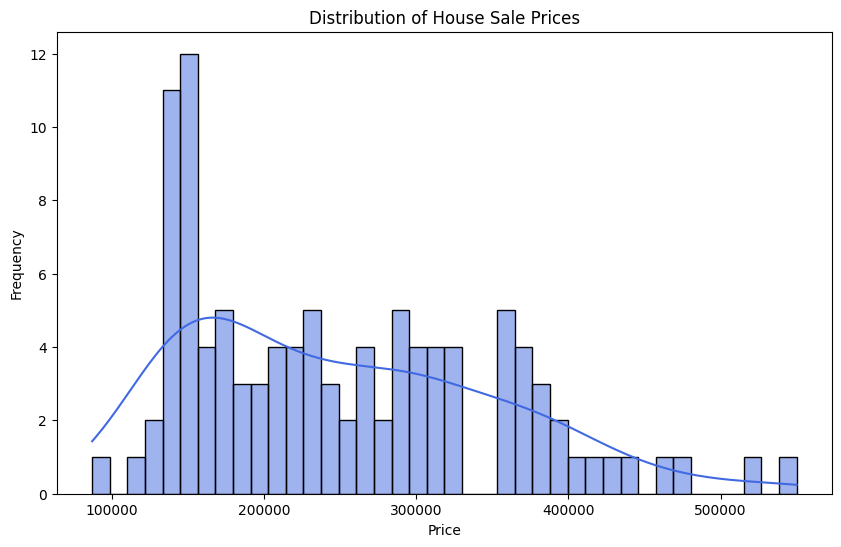

Sold Price Statistics:
Min: 87000
Max: 550000
Mean: 250857.62
Median: 233000.00
Lower Quartile: 156000.00
Upper Quartile: 315000.00
Standard deviation: 101458.82
Skewness: 0.69


In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(housing_df['sold_price'], bins=40, kde=True, color='royalblue')
plt.title('Distribution of House Sale Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

print(f"Sold Price Statistics:")
print(f"Min: {housing_df['sold_price'].min()}")
print(f"Max: {housing_df['sold_price'].max()}")
print(f"Mean: {housing_df['sold_price'].mean():.2f}")
print(f"Median: {housing_df['sold_price'].median():.2f}")
print(f"Lower Quartile: {housing_df['sold_price'].quantile(0.25):.2f}")
print(f"Upper Quartile: {housing_df['sold_price'].quantile(0.75):.2f}")
print(f"Standard deviation: {housing_df['sold_price'].std():.2f}")
print(f"Skewness: {housing_df['sold_price'].skew():.2f}")

The histogram plot of listing sale prices reveal the following things:

1. The price distribution is right-skewed with a large cluster of prices in the lower ranges of prices with the tail of the distribution extending towards the higher prices. We can also see that the median is closer to the lower quartile.
2. There are a few property prices with very high prices in the 500K range but we should probably not assume them to be outliers.

The right-skewed nature of the price distribution suggests we should apply logarithmic transformation on the target variable, `sold_price`, and check if that lends normality to the price distribution. Log transform often gives us more symmetric distributions that are more stable to work with when fitting a model. So let's go ahead and do that.

In [7]:
housing_df['sold_price_log'] = np.log(housing_df["sold_price"])
housing_df.head()

,floor_size,bed_room_count,built_year,sold_date,sold_price,room_count,garage_size,parking_lot,total_size,sold_price_log
0,2068,3,2003,Aug2015,195500,6,768,3,2836,12.183316
1,3372,3,1999,Dec2015,385000,6,480,2,3852,12.860999
2,3130,3,1999,Jan2017,188000,7,400,2,3530,12.144197
3,3991,3,1999,Nov2014,375000,8,400,2,4391,12.834681
4,1450,2,1999,Jan2015,136000,7,200,1,1650,11.820410


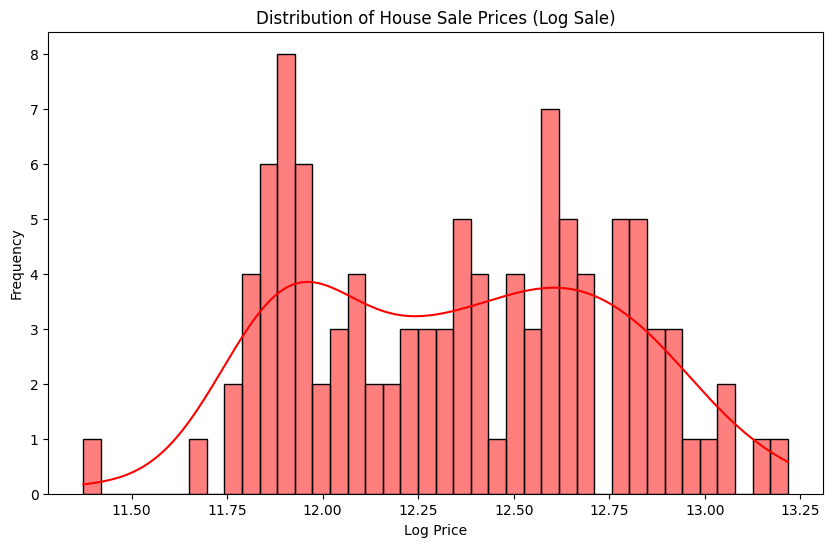

In [8]:
plt.figure(figsize=(10, 6))
# housing_df['sold_price'].plot(kind='hist', bins=10, title='Distribution of House Sale Prices')
sns.histplot(housing_df['sold_price_log'], bins=40, kde=True, color='red')
plt.title('Distribution of House Sale Prices (Log Sale)')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

Most of the features are straightforward and ready to be used. This minimizes our job when it comes to transforming existing features into custom ones. However, it makes sense to manipulate the `sold_date` feature to a new feature: `property_age`. So let us do that first.
We first separate the sale year from the `sold_date` feature and then subtract the `built_year` feature from it to calculate the age of the property.

In [9]:
def get_sale_year(sell_date):
    '''Takes the sell date and extracts the year'''
    return int(sell_date[3:])

def get_property_age(row):
    '''Returns the age of the listing'''
    built_year = row['built_year']
    sale_year = row['sale_year']
    return sale_year-built_year

housing_df['sold_date'] = housing_df['sold_date'].str.strip()
housing_df['sale_year'] = housing_df['sold_date'].apply(get_sale_year)
housing_df['property_age'] = housing_df[['built_year', 'sale_year']].apply(get_property_age, axis=1)
housing_df.head()

,floor_size,bed_room_count,built_year,sold_date,sold_price,room_count,garage_size,parking_lot,total_size,sold_price_log,sale_year,property_age
0,2068,3,2003,Aug2015,195500,6,768,3,2836,12.183316,2015,12
1,3372,3,1999,Dec2015,385000,6,480,2,3852,12.860999,2015,16
2,3130,3,1999,Jan2017,188000,7,400,2,3530,12.144197,2017,18
3,3991,3,1999,Nov2014,375000,8,400,2,4391,12.834681,2014,15
4,1450,2,1999,Jan2015,136000,7,200,1,1650,11.820410,2015,16


In addition, we also plot the data distributions of some of the numeric features that could be essential to our model going forward.

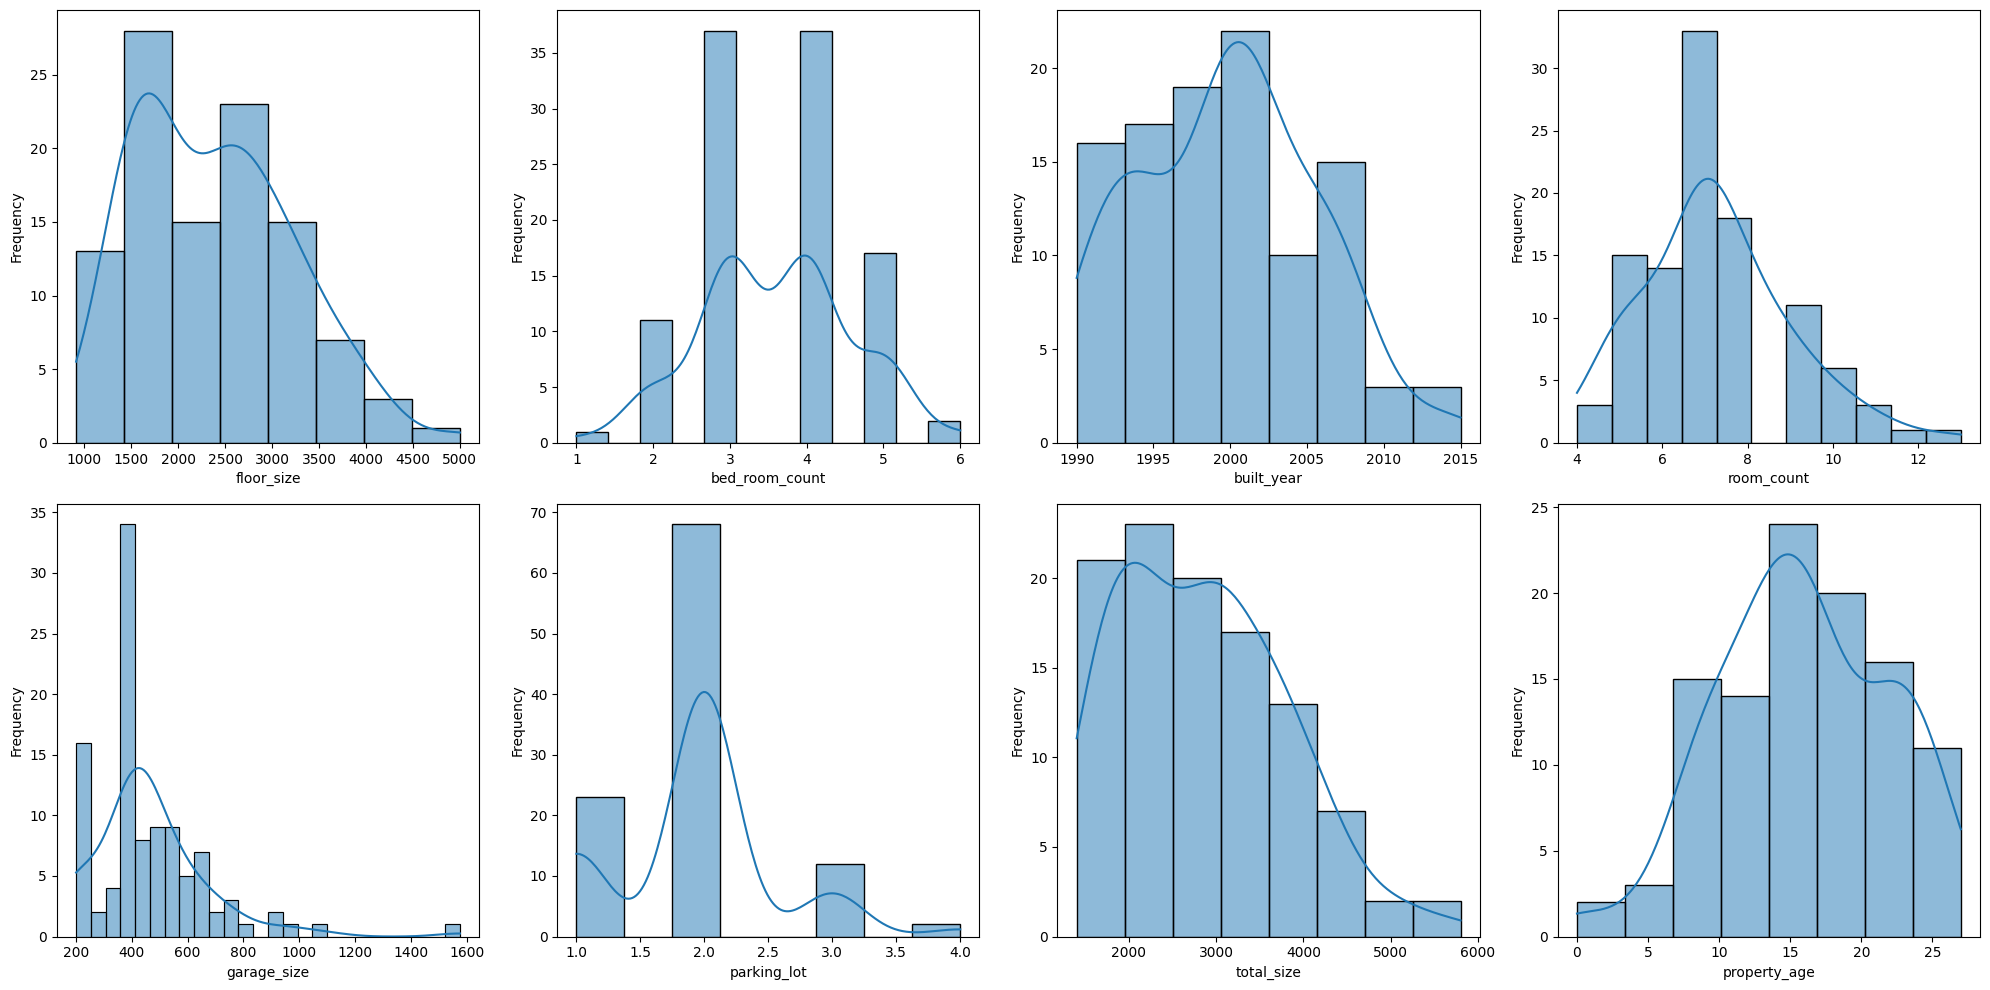

In [10]:
features = ['floor_size','bed_room_count','built_year','room_count','garage_size','parking_lot','total_size','property_age']
plt.figure(figsize=(20, 10), frameon=False)
# Examine distribution of numerical features
for i, col in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.histplot(housing_df[col], kde=True)
    plt.xlabel(col)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

We also notice that the distributions for `floor_size` and `garage_size` exhibit right skewedness. Hence we apply similar log transformations to each of these two features.

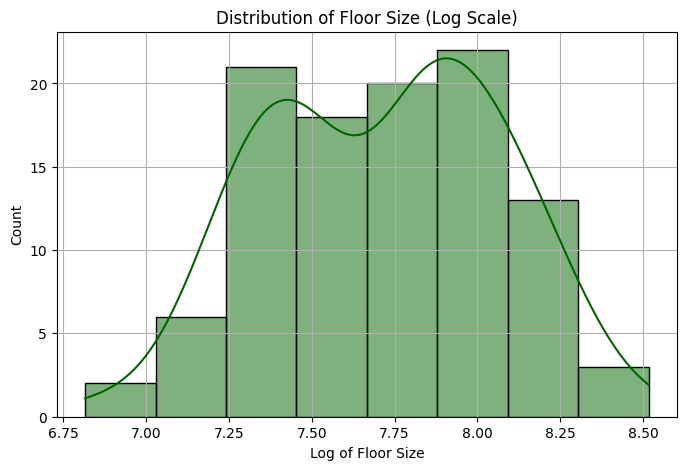

In [11]:
housing_df['floor_size_log'] = np.log(housing_df['floor_size'])
plt.figure(figsize=(8, 5))
sns.histplot(housing_df['floor_size_log'].dropna(), kde=True, color='darkgreen')
plt.title("Distribution of Floor Size (Log Scale)")
plt.xlabel("Log of Floor Size")
plt.ylabel("Count")
plt.grid(True)
plt.show()

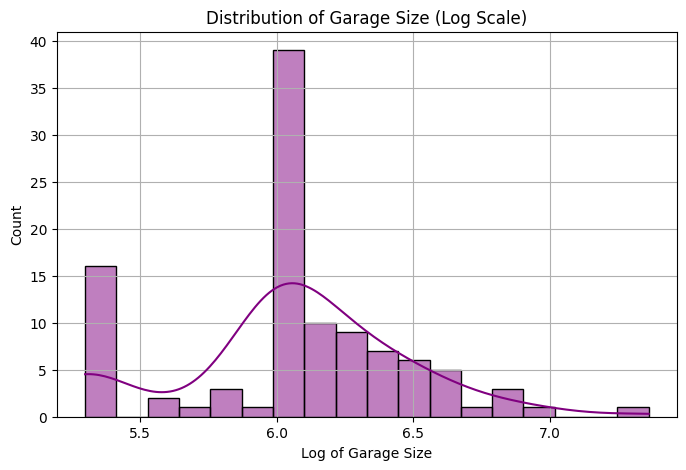

In [12]:
housing_df['garage_size_log'] = np.log(housing_df['garage_size'])
plt.figure(figsize=(8, 5))
sns.histplot(housing_df['garage_size_log'].dropna(), kde=True, color='purple')
plt.title("Distribution of Garage Size (Log Scale)")
plt.xlabel("Log of Garage Size")
plt.ylabel("Count")
plt.grid(True)
plt.show()

We also do not have any categorical feature in the data that would require additional transformation. Finally, we notice that the feature `total_size` is computed by adding the feature values from `floor_size` and `garage_size`. Hence it is important to **drop** the `total_size` feature. Otherwise, we introduce the issue of **multicollinearity** -- a phenomenon where two or more features have a linear relationship. In this case, the linear relationship goes as follows: 
>  $total\_size = floor\_size + garage\_size$

Multicollinearity shows the presence of highly correlated predictors such that change in values of one feature can impact the other. Multicollinearity can lead to unstable regression coefficients and makes it difficult to determine the impact of each predictor on the response variable.  
With the feature transformations concluded above, our feature engineering steps will now consist of standardizing the following numeric features:
- `floor_size_log`
- `bed_room_count`
- `built_year`
- `room_count`
- `garage_size_log`
- `parking_lot`
- `property_age`

We also include the column for the original target variable `sold_price`, but this is for record keeping purposes so that we can evaluate the performance of the predicted values on the original scale instead of the log scale. We will be dropping this column prior to sending the other features for model fitting.

In [13]:
column_list = ['floor_size_log','bed_room_count','built_year','room_count','garage_size_log','parking_lot','property_age','sold_price']
housing_data_df = housing_df[column_list]
housing_data_df.head()

,floor_size_log,bed_room_count,built_year,room_count,garage_size_log,parking_lot,property_age,sold_price
0,7.634337,3,2003,6,6.643790,3,12,195500
1,8.123261,3,1999,6,6.173786,2,16,385000
2,8.048788,3,1999,7,5.991465,2,18,188000
3,8.291797,3,1999,8,5.991465,2,15,375000
4,7.279319,2,1999,7,5.298317,1,16,136000


The response variable for this problem are the prices of the listings in our dataset but in the log scale.

In [14]:
housing_data_prices_log = housing_df['sold_price_log']
housing_data_prices_log.head()

0    12.183316
1    12.860999
2    12.144197
3    12.834681
4    11.820410
Name: sold_price_log, dtype: float64

Prior to applying standardization to numeric features, we split the dataset into training and test data. We do that by using the `train_test_split` function and also specifying the fraction of the whole data we want to use for testing. This is done to prevent any information leakage between training and test partitions that could inadvertently lead to over-optimistic performance projections.

In [15]:
housing_data_df_train, housing_data_df_test, housing_data_prices_log_train, housing_data_prices_log_test = train_test_split(housing_data_df, housing_data_prices_log, test_size=0.2, random_state=42)

Now we calculate the mean and standard deviation of each numeric feature from the training split only and use the same to standardize each feature distribution in both the training and test data splits.  
We use `StandardScaler` from the `scikit-learn` module. The `fit_transform` function calculates the means and standard deviations on the training data and then applies them to scale the feature values. 
At the end of this step, each feature distribution is transformed into one with 0 mean and unit variance.  
Prior to that, we drop the column containing the original sale prices since we do not want them to be scaled and included with the rest of the features.

In [16]:
# Drop the column with original sale prices from both training and test
column_to_remove = 'sold_price'
X_train = housing_data_df_train.drop(column_to_remove, axis=1)
X_test = housing_data_df_test.drop(column_to_remove, axis=1)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[-1.28069849, -1.71273365, -0.07511407, -0.19081012, -1.89962655,
        -1.55561249,  0.11973039],
       [ 1.04806783,  1.41486693, -0.7392806 ,  0.91457265, -0.21847199,
         0.09845649,  0.60637651],
       [ 1.44058327,  1.41486693,  1.25321898,  0.91457265,  0.24385737,
         0.09845649, -1.01577721],
       [-1.96993826,  0.3723334 , -0.57323896, -0.19081012,  0.24385737,
         0.09845649,  0.28194576],
       [-0.48586513, -0.67020012,  1.08717735, -0.19081012,  0.01269269,
         0.09845649, -1.17799258],
       [ 0.40499387,  0.3723334 ,  1.08717735, -0.19081012,  0.01269269,
         0.09845649, -1.17799258],
       [ 0.51272075,  0.3723334 ,  1.58530224, -0.19081012, -0.21847199,
         0.09845649, -1.66463869],
       [ 0.79984717,  0.3723334 ,  1.58530224, -0.19081012,  0.41786456,
         0.09845649, -1.66463869],
       [ 1.1417126 ,  0.3723334 , -1.07136386,  0.36188127,  1.220579  ,
         1.75252546,  0.93080725],
       [ 1.03466504,  0.3723

For the test split we use the `transform` function on the existing scaler. This standardizes feature values in the test data by applying the same transformations derived from the feature distributions in the training set. Note that it is important to **not** refit the scaler again, separately, on the test data.

In [18]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[ 0.88096664,  0.3723334 ,  0.25696919,  0.36188127,  1.35734882,
         1.75252546, -0.36691572],
       [ 0.18969611, -0.67020012,  1.08717735, -1.2961929 ,  0.6148682 ,
         0.09845649, -1.17799258],
       [ 0.21472153,  0.3723334 ,  1.41926061, -0.19081012, -0.21847199,
         0.09845649, -1.17799258],
       [ 0.40499387,  0.3723334 ,  1.08717735,  0.36188127, -0.21847199,
         0.09845649, -1.17799258],
       [-0.97596622, -1.71273365,  0.42301082, -1.2961929 , -1.89962655,
        -1.55561249, -0.36691572],
       [ 0.55405369,  1.41486693, -1.40344712,  0.36188127, -0.21847199,
         0.09845649,  1.41745336],
       [-0.86463962, -1.71273365,  0.25696919, -0.74350151, -0.21847199,
         0.09845649, -0.52913109],
       [ 1.50004251,  1.41486693,  0.09092756, -0.19081012, -0.21847199,
         0.09845649, -0.20470035],
       [ 0.6114808 ,  1.41486693,  0.25696919, -0.19081012, -0.21847199,
         0.09845649, -0.36691572],
       [-0.21863178, -0.6702

Now let us fit a linear regression model to predict the housing prices from the available features as well as identify the most important features in the data that enables us to do so. To do this, we will use `SequentialFeatureSelector` from the `mlxtend` module. The `SequentialFeatureSelector` is capable of performing either forward selection or backward elimination of features depending on their importance in predicting the response variable. Both techniques are variations of a greedy feature selection process that has been explained in the [previous section](../../20/2/feature_selection.ipynb).

In [19]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

We start by initializing the `SequentialFeatureSelector` with a model instance, as is appropriate for the prediction problem at hand. Here our model of choice is Linear Regression. In addition, we set the values of a few more important parameters.
- $k\_features$ : We can either limit the number of features to be selected from the feature set or set this parameter to $best$ in which case the feature selector will choose the subset that yields the best cross-validation performance.
- $forward$ : When set to $True$ the feature selector runs the forward selection algorithm. Otherwise, it can be set to $False$ when backward elimination is executed.
- $scoring$ : A number of accuracy/error metrics are available to evaluate the model performance with each feature set that is iteratively selected during sequential feature selection. For this regression problem, we choose the $R^2$ metric. Alternatives include mean squared error, mean absolute error, etc.
- $cv$: When set to an integer $k$, the selector will use $k$-fold cross validation to split data into training and validation splits. Intermediate versions of the model are iteratively trained with different feature sets on the training splits and evaluated on the validation split. We will discuss cross-validation in greater detail in [Chapter 21](../../21/placeholder21.ipynb).

Once the feature selector has been appropriately initialized, we call the `fit` function to perform sequential feature selection alongside the model of choice and determine the optimal feature subset.

In [20]:
lr = LinearRegression()

sfs = SFS(lr, 
          k_features='best', 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=3)

sfs = sfs.fit(X_train_scaled, housing_data_prices_log_train)

To get a breakdown of the feature selector's execution at the end of each iteration, we can call the `get_metric_dict` function. Here we print the execution report in the form of a dataframe. We see the feature selected in each iteration and how the model performance, as given by the average cross-validation score, changes accordingly. As seen below, the optimal feature set for the housing prices prediction problem seems to be selected in the fourth iteration as the corresponding average cross-validation score, using the $R^2$ metric is highest for that iteration.

In [21]:
sfs_metric_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sfs_metric_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(0,)","[0.8011541407669223, 0.5979697556955595, 0.518...",0.639148,"(0,)",0.267973,0.119082,0.084203
2,"(0, 5)","[0.7373225274223243, 0.6709184297106074, 0.603...",0.670642,"(0, 5)",0.122773,0.054558,0.038578
3,"(0, 1, 5)","[0.7261841998683258, 0.6921919520698298, 0.615...",0.678081,"(0, 1, 5)",0.103804,0.046129,0.032618
4,"(0, 1, 2, 5)","[0.7160295872355962, 0.7049961004106151, 0.627...",0.682688,"(0, 1, 2, 5)",0.089129,0.039607,0.028006
5,"(0, 1, 2, 5, 6)","[0.706748962481389, 0.7051984593000533, 0.6222...",0.678081,"(0, 1, 2, 5, 6)",0.088778,0.039451,0.027896
6,"(0, 1, 2, 3, 5, 6)","[0.707059205186533, 0.6965157705757061, 0.6107...",0.671426,"(0, 1, 2, 3, 5, 6)",0.097109,0.043153,0.030514
7,"(0, 1, 2, 3, 4, 5, 6)","[0.6816988966656055, 0.6713140577899961, 0.581...",0.644916,"(0, 1, 2, 3, 4, 5, 6)",0.100986,0.044876,0.031732


To get a sense of the actual features being selected, we can also print their names by following the indices of the selected features in the list of features that were initially passed to the feature selector. For the current problem, the optimal feature set include 4 features as determined by the sequential feature selector:
- `floor_size_log`
- `bed_room_count`
- `built_year`
- `parking_lot`

In [22]:
k = len(sfs.k_feature_names_)
print(f'k: {k}')
pprint([column_list[int(feature_index)] for feature_index in list(sfs.k_feature_names_)])

k: 4
['floor_size_log', 'bed_room_count', 'built_year', 'parking_lot']


We can also visualize the iterative feature selection process by using the `plot_sfs` function available within the `mlxtend` module.

0.6391475579206499 0.682688058191487


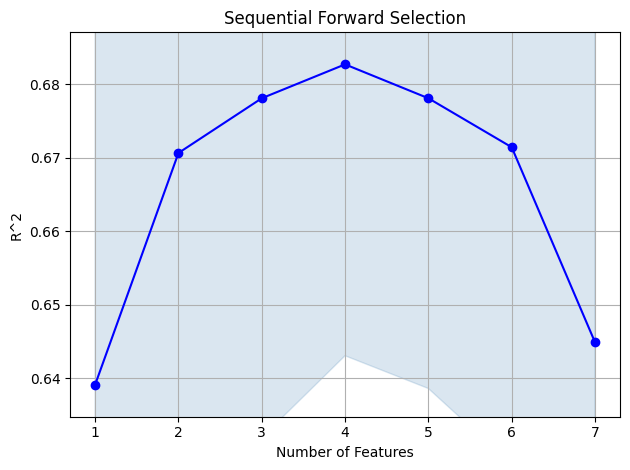

In [23]:
min_r2_score = sfs_metric_df['avg_score'].min()
max_r2_score = sfs_metric_df['avg_score'].max()
margin = (max_r2_score - min_r2_score)*0.1
print(min_r2_score, max_r2_score)

fig = plot_sfs(sfs.get_metric_dict(), ylabel='R^2')
plt.ylim([min_r2_score-margin, max_r2_score+margin])
plt.title('Sequential Forward Selection')
plt.grid()
plt.tight_layout()
plt.show()

Once the optimal feature set has been selected, the linear regression model is trained on the whole training data. First we separate the features suggested by the selector from the whole training data. The `sfs.transform()` function accomplishes this. Next we call the `fit` function on the linear regression model to train it on the selected features and corresponding target variable values, as obtained from the training split. Here, we print the model coefficients associated with each feature at the end of model training as well as the intercept term.  
We also compute the $R^2$ score on the training fit to compare it with the test performance.

In [24]:
X_train_scaled_sfs = sfs.transform(X_train_scaled)
lr.fit(X_train_scaled_sfs, housing_data_prices_log_train)

k = len(sfs.k_feature_names_)
n = X_train_scaled.shape[0]
r2 = sfs.k_score_
adj_r2 = 1 - (1 - sfs.k_score_) * ((n - 1) / (n - k - 1))

# Print the coefficients and intercept
print(f"Coefficients: {lr.coef_}")
print(f"Intercept: {lr.intercept_}")
print("")
print(f'TRAIN R2: {r2}')
print(f'TRAIN ADJUSTED R2: {adj_r2}')

Coefficients: [0.24111826 0.04644596 0.03113367 0.09764008]
Intercept: 12.388289869468666

TRAIN R2: 0.682688058191487
TRAIN ADJUSTED R2: 0.6666216307581445


Upon fitting the model, we can now use it to make prediction on the test data. Again we use the `sfs.transform()` function to select the subset of features that was deemed to be optimal by the selector from the test data. Next we call the `predict` function on the fitted model and pass the feature subset from the test data to get our predictions. Note that for this problem, we deemed it appropriate to transform the response variable, `sold_price` from the absolute scale to the log scale. This was done to obtain a more symmetric distribution of the response variable. Hence the predicted values obtained from our model on the test data are also not the actual sale prices but those on the log scale.  
We print the $R2$ score on the test predictions to compare the change in performance from training to test data. In this case, the $R^2$ score dropped from 0.67 on the training data to 0.31 on the test.

In [25]:
X_test_scaled_sfs = sfs.transform(X_test_scaled)
y_pred_log = lr.predict(X_test_scaled_sfs)
test_r2 = r2_score(housing_data_prices_log_test, y_pred_log)
adj_test_r2 = 1 - (1 - test_r2) * ((n - 1) / (n - k - 1))
print(f'TEST R2: {test_r2}')
print(f'TEST ADJUSTED R2: {adj_test_r2}')

TEST R2: 0.3070768940772879
TEST ADJUSTED R2: 0.2719921798533531


Due to the initial log-transformation conducted on the target variable, the fitted model predicts selling prices on the log-scale. Thus for us to generate the predicted price of a listing in the original scale, we need to perform an inverse exponential transformation on the predicted values. Once that is done, we compare the predicted values with the actual values of the `sold_price` column in the test data.  
We use root mean squared error (**RMSE**) as the metric of choice to determine the deviation between the predicted selling prices and the actual prices.

In [26]:
y_pred = np.exp(y_pred_log)
rmse = np.sqrt(mean_squared_error(housing_data_df_test['sold_price'].values, y_pred))

output_df = pd.DataFrame({
    "Actual_price": housing_data_df_test['sold_price'].values,
    "Predicted_price": y_pred,
})

print(f"Test RMSE: {rmse:,.0f}")
print("\nSold price predictions:")
print(output_df.to_string(index=False, formatters={
    "Actual_price": "{:,.0f}".format,
    "Predicted_price": "{:,.0f}".format,
}))

Test RMSE: 65,749

Sold price predictions:
Actual_price Predicted_price
     300,000         361,175
      87,000         254,323
     384,000         271,348
     222,000         281,165
     140,000         152,466
     270,000         283,089
     158,000         183,116
     375,000         372,554
     315,000         302,264
     195,500         266,706
     200,000         282,383
     117,300         192,142
     152,000         186,861
     290,000         318,510
     267,500         233,394
     136,000         142,490
     210,200         273,120
     135,000         133,183
     155,000         284,490
     310,700         295,520
     145,000         153,608
